In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import kvn

colors_ = ["blue", "red", "green", "gray", "black"]

5256
c:\Users\novikau1\Documents\work\codes\QuCF\scripts-py


In [2]:
path_save_ = "./jupyter-notebooks/NL/results/"
for i in range(30):
    plt.close()

In [3]:
# ------------------------------------------------------------------------
def get_dk(norm_Ah_in, norm_Aa_in, t_in, n_dk):
    # dk_res = 0.01 * 2.*np.pi / (norm_Ah_in * t_in)
    # if dk_res >= 2. * k_max_in:
    #     dk_res = 2. * 10 / (1<<(5 + n_dk) - 1)

    # --- fix dk [defined by n_dk] ---
    # REMARK: for very large norm_Ah or t, dk should be inverse to these values, 
    # otherwise, it seems that dk is defined more by the integral discretization error
    # (trapezoidal error: kmax**3/M**2)
    nk = 5 + n_dk
    Nk = 1 << nk
    dk_res = 2. * 10. / (Nk - 1)
    return dk_res
# ------------------------------------------------------------------------
def get_trot(norm_Ah_in, norm_Aa_in, t_in, coef_trot_in, k_max_in):
    # non-normalized time step for the trotterization:
    temp = norm_Ah_in * k_max_in
    if temp >= norm_Aa_in:
        tau_res = coef_trot_in * 1. / temp
        if tau_res >= t_in:
            tau_res = t_in
    else:
        tau_res = coef_trot_in * 1. / norm_Aa_in

    # number of trotterization steps:
    Nt_trot_res = int(t_in / tau_res)
    if Nt_trot_res <= 0:
        Nt_trot_res = 1
    return tau_res, Nt_trot_res
# ------------------------------------------------------------------------
def get_max_err(t_ref, psi_ref, t_LCHS, psi_LCHS, coef_sign):
    max_abs_err = 0
    for id_var in range(2):
        for it in range(len(t_LCHS)):
            t1 = t_LCHS[it]
            v_ref = np.interp(t1, t_ref, psi_ref[:, id_var])  
            err = np.max(np.abs(v_ref - coef_sign * psi_LCHS[it, id_var]))
            if max_abs_err < err:
                max_abs_err = err
    print("max. abs. err: {:0.3e}".format(max_abs_err))
    return

In [4]:
# --------------------------------------------------------
# --- Parameters: single time ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

# ---------------------------------------------------------
# --- Choose weak or strong dissipation ---
sel_case_ = 2

str_case_ = ""
if sel_case_ == 1:
    coef_sign_ = 1
    str_case_ = "WD"
if sel_case_ == 2:
    coef_sign_ = 1
    str_case_ = "SD"

# Chosen Hamiltonian * i:
Hi_ = kvn.get_case_Hi(sel_case_)

# Hermitian and anti-Hermitian parts of Hi_:
Ah_, Aa_ = mix.get_herm_aherm_parts(Hi_)

# the norm of Ah (multiplied by the matrix nonsparsity):
_, norm_Ah_, _ = mix.compute_normalized_matrix(Ah_, "Ah", True)
_, norm_Aa_, _ = mix.compute_normalized_matrix(Aa_, "Aa", True)
print()
print("norm-Ah: {:0.3e}".format(norm_Ah_))
print("norm-Aa: {:0.3e}".format(norm_Aa_))
print()

# --- initial state ---
psi_init_ = kvn.get_initial_state()

# ---------------------------------------------------------
# --- Parameters for the reference signal ---
nt_ref_     = 12
t_max_ref_  = 4

Nt_ref_ = 1 << nt_ref_
t_ref_  = np.linspace(0, t_max_ref_, Nt_ref_)
dt_ref_ = np.diff(t_ref_)[0]

# --- reference computation ---
print()
print("Reference computation")
psi_ref_ = kvn.ref_computation(t_ref_, Hi_, psi_init_)
print("Done")

--- Strong non-Hermiticity ---
Matrix Ah:	 nonsparsity, coefnorm: 1, 1.000e+00
Matrix Aa:	 nonsparsity, coefnorm: 2, 4.472e+00

norm-Ah: 1.000e+00
norm-Aa: 4.472e+00


Reference computation

--- refence computation ---
sum psi[RK-max-time]**2: 2.174e-02
Done


In [16]:
# ------------------------------------------------------------------
# --- LCHS-python simulation ---
# ------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
def computation_LCHS_py():
    step_t_id = 10
    n_dk, coef_trot = 0, 1.0

    #      for n_dk = 0
    # *** nk = 4  --> kmax = 5 ***
    # *** nk = 5  --> kmax = 10 ***
    # *** nk = 6  --> kmax = 20 ***
    # *** nk = 7  --> kmax = 40 ***
    nk = 6 + n_dk

    # ---------------------
    Nk = 1<<nk
    t_LCHS_py = np.zeros(Nt_ref_)
    psi_LCHS_py = np.zeros((Nt_ref_, 2), dtype = complex)
    counter_t = -1

    print()
    print("LCHS-python computation: sel-case, nk: ", sel_case_, nk)
    for it in range(0, Nt_ref_, step_t_id):
        counter_t += 1
        t1 = t_ref_[it]
        t_LCHS_py[counter_t] = t1

        dk = get_dk(None, None, None, n_dk)
        k_max_py = 0.5 * dk * (Nk - 1)
        k_grid = np.linspace(-k_max_py, k_max_py, Nk)
        if counter_t == 0:
            print("dk, kmax: {:0.3e}, {:0.3f}".format(dk, k_max_py))

        if t1 > 0:
            tau, N_steps = get_trot(norm_Ah_, norm_Aa_, t1, coef_trot, k_max_py)
            # print("t, tau, N_steps: {:0.3e}, {:0.3e}, {:d}".format(t1, tau, N_steps))
        else:
            tau = 0
            N_steps = 0

        t_LCHS_py[counter_t] = tau * N_steps # correct the time moment for the LCHS

        psi_LCHS_py[counter_t, :] = kvn.LCHS_computation(
            k_grid, tau,
            Hi_, psi_init_, N_steps, 
            flag_trotterization = True, 
            flag_print = False
        )
    t_LCHS_py = t_LCHS_py[:counter_t+1]
    psi_LCHS_py = psi_LCHS_py[:counter_t+1, :]
    print("Done.")
    return psi_LCHS_py, t_LCHS_py, step_t_id
# -------------------------------------------
psi_LCHS_py, t_LCHS_py, step_t_id = computation_LCHS_py()
get_max_err(t_ref_, psi_ref_, t_LCHS_py, psi_LCHS_py, 1.0)


LCHS-python computation: sel-case, nk:  2 6
dk, kmax: 6.452e-01, 20.323
Done.
max. abs. err: 2.231e-02


In [8]:
# ---------------------------------------------------------------------------------
# --- Scans from py LCHS simulations ---
# ---------------------------------------------------------------------------------
mix.reload_module(mix)
def scan_error():
    def save_data(str_sel, dk, x_data, y_data, coef_trot):
        mix.save_dat_plot_1d_file(
            path_save_ + "/py_LCHS_{:s}_dk{:d}_trot{:d}_kmax_err.dat".format(
                str_sel, int(1000*dk), int(10*coef_trot)
            ),    
            x_data, y_data
        )
        return
    # ----------------------------------------------------------------------
    nt_ref = 12
    
    # -------------------------------------
    # coef_trot, step_t_id = 0.1, 10

    # str_sel, dk = "sD", 6.452e-01
    # kmax_arr = [    4.839,        10,    20.323,    40.968,    82.258]
    # err_arr  = [1.302e-01, 6.361e-02, 3.142e-02, 1.602e-02, 8.367e-03]
    # save_data(str_sel, dk, np.array(kmax_arr), np.array(err_arr), coef_trot)

    # str_sel, dk = "sD", 1.575e-01
    # kmax_arr = [    4.961,        10,    20.079,    40.236,    80.551]
    # err_arr  = [1.267e-01, 6.345e-02, 3.168e-02, 1.629e-02, 8.502e-03]
    # save_data(str_sel, dk, np.array(kmax_arr), np.array(err_arr), coef_trot)

    # -------------------------------------
    coef_trot, step_t_id = 1.0, 10

    str_sel, dk = "sD", 6.452e-01
    kmax_arr = [    4.839,        10,    20.323,    40.968,    82.258]
    err_arr  = [1.302e-01, 6.361e-02, 3.142e-02, 1.565e-02, 8.254e-03]
    save_data(str_sel, dk, np.array(kmax_arr), np.array(err_arr), coef_trot)


    str_sel, dk = "sD", 1.575e-01
    kmax_arr = [    4.961,        10,    20.079,    40.236,    80.551]
    err_arr  = [1.267e-01, 6.345e-02, 3.168e-02, 1.590e-02, 8.395e-03]
    save_data(str_sel, dk, np.array(kmax_arr), np.array(err_arr), coef_trot)

    return
# ----------------------------------------------------------------------------------
scan_error()

write data to a file: ./jupyter-notebooks/NL/results//py_LCHS_sD_dk645_trot10_kmax_err.dat
write data to a file: ./jupyter-notebooks/NL/results//py_LCHS_sD_dk157_trot10_kmax_err.dat


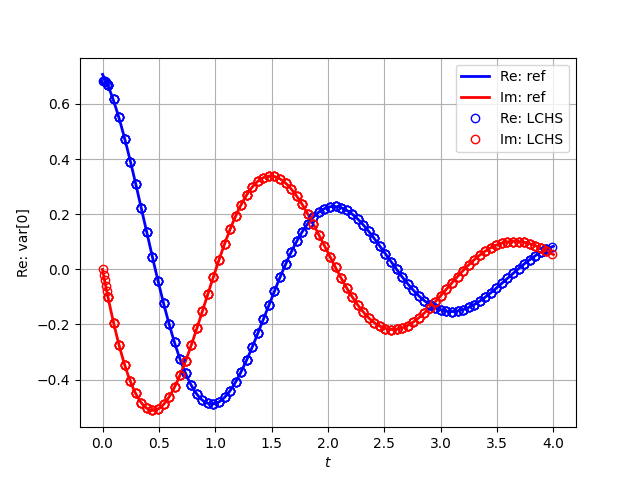

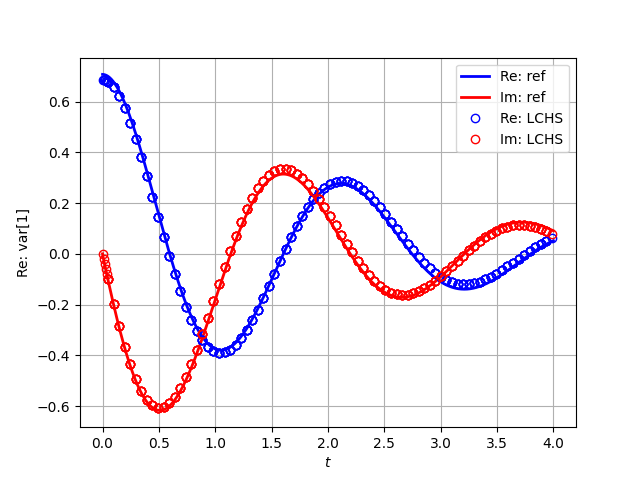

In [17]:
# ------------------------------------------------------------------
# --- Plottting the reference and the LCHS-python computations ---
# ------------------------------------------------------------------
mix.reload_module(kvn)
kvn.compare_plots_ref_LCHS_py(t_ref_, t_LCHS_py, psi_ref_, psi_LCHS_py, id_var = 0)
kvn.compare_plots_ref_LCHS_py(t_ref_, t_LCHS_py, psi_ref_, psi_LCHS_py, id_var = 1)

In [10]:
# ------------------------------------------------------------
# --- Initial parameters for the LCHS-QuCF simulation ---
# ------------------------------------------------------------

k_max_, nk_, coef_trot_ = 10, 5, 1.0
# k_max_, nk_, coef_trot_ = 40.968, 7, 1.0

flag_AA_ = True

t_qc_ = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]  # non-normalized time points

# --- Fourier k-grid ---
Nk_ = 1 << nk_
dk_ = get_dk(None, None, None, n_dk=0)
k_max_ = 0.5 * dk_ * (Nk_ - 1)

# --- Path with the QuCF simulation ---
path_qucf_ = "../QuCF/simulations/LCHS/"
if sel_case_ == 1:
    path_qucf_ += "WD-"
if sel_case_ == 2:
    path_qucf_ += "SD-"

path_qucf_ += "kmax{:d}".format(int(k_max_))

if flag_AA_:
    path_qucf_ += "-AA"
else:
    path_qucf_ += "-woAA"

# --- Print parameters ---
print("Chosen parameters for the LCHS-QuCF simulation")
print("kmax, nk, dk:\t {:0.3f}, {:d}, {:0.3e}".format(k_max_, nk_, dk_))
if flag_AA_:
    print("with the AA of the LCHS weights")
else:
    print("without the AA of the LCHS weights")
print("LCHS-QuCF path:\t {:s}".format(path_qucf_))

Chosen parameters for the LCHS-QuCF simulation
kmax, nk, dk:	 10.000, 5, 6.452e-01
with the AA of the LCHS weights
LCHS-QuCF path:	 ../QuCF/simulations/LCHS/SD-kmax10-AA


In [11]:
# ------------------------------------------------------------
# --- Parameters for the BE ---
# ------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

def compute_angles_2x2(A_norm, nonsparsity, str_A):
    ay_00, az_00 = mix.calc_angles_from_a_value(A_norm[0,0] * nonsparsity)
    ay_01, az_01 = mix.calc_angles_from_a_value(A_norm[0,1] * nonsparsity)
    ay_10, az_10 = mix.calc_angles_from_a_value(A_norm[1,0] * nonsparsity)
    ay_11, az_11 = mix.calc_angles_from_a_value(A_norm[1,1] * nonsparsity)
  
    print("ay_00_{:s}  {:0.12e}".format(str_A, ay_00))
    if az_00 is not None:
        print("az_00_{:s}  {:0.12e}".format(str_A, az_00))

    print("ay_01_{:s}  {:0.12e}".format(str_A, ay_01))
    if az_01 is not None:
        print("az_01_{:s}  {:0.12e}".format(str_A, az_01))

    print("ay_10_{:s}  {:0.12e}".format(str_A, ay_10))
    if az_10 is not None:
        print("az_10_{:s}  {:0.12e}".format(str_A, az_10))

    print("ay_11_{:s}  {:0.12e}".format(str_A, ay_11))
    if az_11 is not None:
        print("az_11_{:s}  {:0.12e}".format(str_A, az_11))
    return
# --------------------------------------------------------------------------------------------  
# 
flag_print_matrix = False  
    
# --- Find Hermitian and anti-Hermitian parts of the system ---
Ah, Aa = mix.get_herm_aherm_parts(Hi_)

if flag_print_matrix:
    print("\n*** Hermitian part of i*H (Ah) ***")
    mix.print_matrix(Ah)

    print("\n*** Anti-Hermitian part of i*H (Aa) ***")
    mix.print_matrix(Aa)

Ba     = Aa 
B_kmax = - k_max_ * Ah
Bk     =      dk_ * Ah

# --- Normalize the hermitian and anti-Hermitian parts of the matrix ---
Ba_norm,     ncoef_a,    nonsparsity_a    = mix.compute_normalized_matrix(Ba, "Ba", True)
B_kmax_norm, ncoef_kmax, nonsparsity_kmax = mix.compute_normalized_matrix(B_kmax, "B_kmax", True)
Bk_norm,     ncoef_k,    nonsparsity_k    = mix.compute_normalized_matrix(Bk, "Bk", True)

if flag_print_matrix:
    print("\n*** Normalized Aa ***")
    mix.print_matrix(Ba_norm, ff=[25, 3, "e"])

    print("\n*** Normalized ( - kmax*Ah) ***")
    mix.print_matrix(B_kmax_norm, ff=[25, 3, "e"])

    print("\n*** Normalized dk*Ah ***")
    mix.print_matrix(Bk_norm, ff=[25, 3, "e"])

    # Print initial state:
    print("\n*** Initial state ***")
    mix.print_array(psi_init_, ff=[25, 3, "e"])

# --- The number of qubits for encoding variables ---
print("\n//--- For data ---")
print("nx \t{:d}".format(1))

# --- Compute angles for the herm. and a-herm. matrices ---
print("\n//--- The angles for the BE oracles ---")
if nonsparsity_a > 0:
    compute_angles_2x2(Ba_norm,     nonsparsity_a,    "a")
if nonsparsity_kmax > 0:
    compute_angles_2x2(B_kmax_norm, nonsparsity_kmax, "kmax")
if nonsparsity_k > 0:
    compute_angles_2x2(Bk_norm,     nonsparsity_k,    "k")

# --- Compute angles for the initialization circuit ---
print("\n//--- The angles for the initialization ---")
kvn.compute_angles_initialization(psi_init_)

# --- Compute angles for the weights ---
print("\n//--- Angles for the weight-oracle ---")
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)

print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))

Matrix Ba:	 nonsparsity, coefnorm: 2, 4.472e+00
Matrix B_kmax:	 nonsparsity, coefnorm: 1, 1.000e+01
Matrix Bk:	 nonsparsity, coefnorm: 1, 6.452e-01

//--- For data ---
nx 	1

//--- The angles for the BE oracles ---
ay_00_a  2.214297435588e+00
ay_01_a  9.272952180016e-01
ay_10_a  9.272952180016e-01
ay_11_a  2.214297435588e+00
ay_00_kmax  6.283185307180e+00
ay_01_kmax  3.141592653590e+00
ay_10_kmax  3.141592653590e+00
ay_11_kmax  3.141592653590e+00
ay_00_k  0.000000000000e+00
ay_01_k  3.141592653590e+00
ay_10_k  3.141592653590e+00
ay_11_k  3.141592653590e+00

//--- The angles for the initialization ---
ay_init  3.141592653590e+00

//--- Angles for the weight-oracle ---
nk 	5
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.032258064516e+00


In [12]:
# ----------------------------------------------------------
# --- Trotterization steps ---
# ----------------------------------------------------------
def compute_trotterization_parameters():
    N_points = len(t_qc_)
    tau_array = np.zeros(N_points) 
    Nt_array  = np.zeros(N_points, dtype=int)
    t_qc_res_ = np.zeros(N_points)
    for it in range(N_points):
        tau_array[it], Nt_array[it] = get_trot(norm_Ah_, norm_Aa_, t_qc_[it], coef_trot_, k_max_)
        t_qc_res_[it] = Nt_array[it] * tau_array[it]

    # --- Normalized short-time intervals for the QSP circuits ---
    for it in range(N_points):
        tau_1 = tau_array[it]

        dt_a    = ncoef_a    * tau_1 / 2.
        dt_kmax = ncoef_kmax * tau_1
        dt_k    = ncoef_k    * tau_1
        print("\n-----------------------------------------------")
        print("t = {:0.3e}".format(t_qc_res_[it]))
        print("tau = {:0.3e}".format(tau_1))
        print("Nt\t {:d}".format(Nt_array[it]))
        print("dt_a:    {:0.12e}".format(dt_a))
        print("dt_kmax: {:0.12e}".format(dt_kmax))
        print("dt_k:    {:0.12e}".format(dt_k))
    return t_qc_res_, Nt_array
# --------------------------------------------------
t_qc_res_, Nt_points_ = compute_trotterization_parameters()


-----------------------------------------------
t = 5.000e-01
tau = 1.000e-01
Nt	 5
dt_a:    2.236067977500e-01
dt_kmax: 1.000000000000e+00
dt_k:    6.451612903226e-02

-----------------------------------------------
t = 1.000e+00
tau = 1.000e-01
Nt	 10
dt_a:    2.236067977500e-01
dt_kmax: 1.000000000000e+00
dt_k:    6.451612903226e-02

-----------------------------------------------
t = 1.500e+00
tau = 1.000e-01
Nt	 15
dt_a:    2.236067977500e-01
dt_kmax: 1.000000000000e+00
dt_k:    6.451612903226e-02

-----------------------------------------------
t = 2.000e+00
tau = 1.000e-01
Nt	 20
dt_a:    2.236067977500e-01
dt_kmax: 1.000000000000e+00
dt_k:    6.451612903226e-02

-----------------------------------------------
t = 2.500e+00
tau = 1.000e-01
Nt	 25
dt_a:    2.236067977500e-01
dt_kmax: 1.000000000000e+00
dt_k:    6.451612903226e-02

-----------------------------------------------
t = 3.000e+00
tau = 1.000e-01
Nt	 30
dt_a:    2.236067977500e-01
dt_kmax: 1.000000000000e+00
dt_k:    



Reading the file ../QuCF/simulations/LCHS/SD-kmax10-AA/N_5_OUTPUT.hdf5...
Name of the simulation is N_5
Simulation has been performed  04-22-2024 16:06:26
success prob: 7.763286308299e-01
nk: 5


Reading the file ../QuCF/simulations/LCHS/SD-kmax10-AA/N_10_OUTPUT.hdf5...
Name of the simulation is N_10
Simulation has been performed  04-22-2024 16:06:28
success prob: 3.187916107636e-01
nk: 5


Reading the file ../QuCF/simulations/LCHS/SD-kmax10-AA/N_15_OUTPUT.hdf5...
Name of the simulation is N_15
Simulation has been performed  04-22-2024 16:06:30
success prob: 1.728875376123e-01
nk: 5


Reading the file ../QuCF/simulations/LCHS/SD-kmax10-AA/N_20_OUTPUT.hdf5...
Name of the simulation is N_20
Simulation has been performed  04-22-2024 16:06:33
success prob: 1.543195923337e-01
nk: 5


Reading the file ../QuCF/simulations/LCHS/SD-kmax10-AA/N_25_OUTPUT.hdf5...
Name of the simulation is N_25
Simulation has been performed  04-22-2024 16:06:38
success prob: 6.867882567553e-02
nk: 5


Reading th

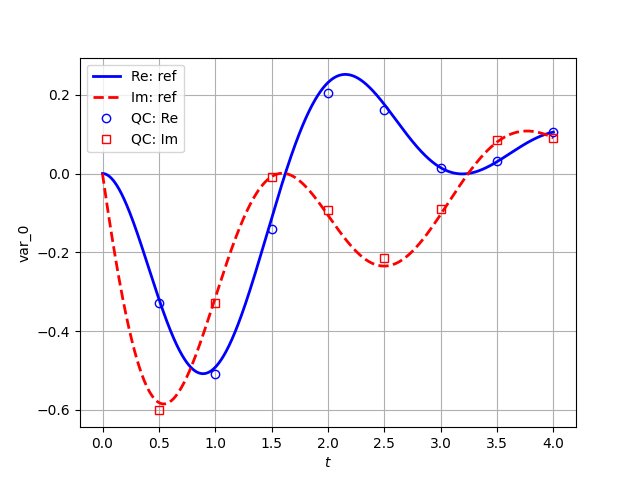

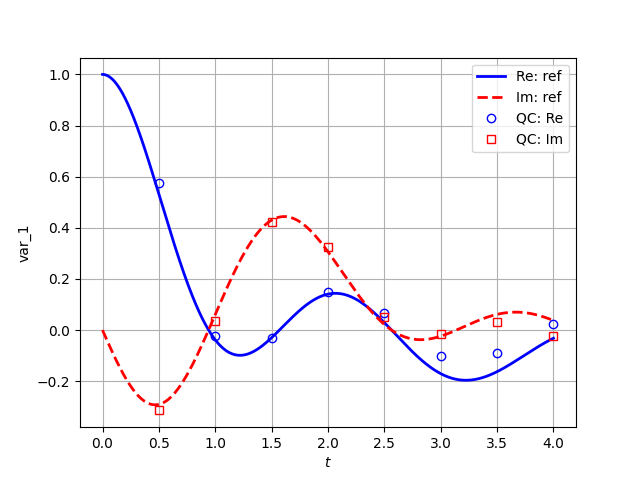

max. abs. err: 8.256e-02


In [13]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------
mix.reload_module(mse)
def plot_QC_vs_REF(t_ref, psi_ref, qt_points, psi_qc, id_var, flag_save):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # --- Plotting ---
    ax.plot(t_ref, psi_ref.real[:,id_var], "-b",  linewidth = 2, label="Re: ref")
    ax.plot(t_ref, psi_ref.imag[:,id_var], "--r", linewidth = 2, label="Im: ref")
    
    ax.plot(
        qt_points, coef_sign_ * psi_qc.real[:,id_var], 
        "o", markerfacecolor='None', markeredgecolor='b', linestyle='None',
        label = "QC: Re"
    )
    ax.plot(
        qt_points, coef_sign_ * psi_qc.imag[:,id_var], 
        "s", markerfacecolor='None', markeredgecolor='r', linestyle='None',
        label = "QC: Im"
    )

    plt.xlabel('$t$')
    plt.ylabel("var_{:d}".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()

    if flag_save:
        if sel_case_ == 1:
            str_sel = "WD"
        elif sel_case_ == 2:
            str_sel = "SD"
        else:
            return
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_REF_RE.dat".format(str_sel, int(k_max_), id_var),    
            t_ref, psi_ref.real[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_REF_IM.dat".format(str_sel, int(k_max_), id_var),    
            t_ref, psi_ref.imag[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_QC_RE.dat".format(str_sel, int(k_max_), id_var),    
            qt_points, coef_sign_ * psi_qc.real[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_QC_IM.dat".format(str_sel, int(k_max_), id_var),    
            qt_points, coef_sign_ * psi_qc.imag[:,id_var]
        )
    return
# ------------------------------------------------------------------------------
def read_data(Nt_point):
    print()  
    pro_name_work = "N_{:d}".format(Nt_point)

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = pro_name_work
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    
    print("success prob: {:0.12e}".format(
        np.sum(np.abs(qc_state_t)**2)
    ))

    # parameters of the k-grid:
    om.read_qsvt()
    nk_c = om.dd_["regs"]["rk"]
    k_max_c = om.dd_["weights"]["par"]
    Nk_c = 1 << nk_c
    k_grid = np.linspace(-k_max_c, k_max_c, Nk_c)
    dk_c = np.diff(k_grid)[0]
    
    print("nk: {:d}".format(nk_c))

    # renormalization:
    Hadamart_norm_factor = 2**(nk_c) 
    coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
    qc_state_t *= coef_norm * (dk_c / np.pi)

    return qc_state_t
# ------------------------------------------------------------------------------
flag_save = False

psi_qc = np.zeros((len(Nt_points_), 2), dtype=complex)
for ii in range(len(Nt_points_)):
    print()
    psi_one = read_data(Nt_points_[ii])
    psi_qc[ii, :] = psi_one  

# --- Plotting ---
psi_ref_norm = np.array(psi_ref_)
psi_qc_norm  = np.array(psi_qc)

# --- For the cases with amplified weights ---
if flag_AA_:
    # ************************************************************************
    # These amplification signals are computed in calc-weights.ipynb 
    # by comparing non-amplified and amplified sqrt(weights) 
    # ************************************************************************
    rr = None
    if int(k_max_) == 10 and nk_ == 5:
        rr = 2.470306404836081
    if int(k_max_) == 40 and nk_ == 7:
        rr = 5.092072717098e+00
    if int(k_max_) == 100 and nk_ == 8:
        rr = 7.925308465279e+00
    print("rr = {:0.12e}".format(rr))
    psi_qc_norm /= rr**2

plot_QC_vs_REF(t_ref_, psi_ref_norm, t_qc_res_, psi_qc_norm, id_var = 0, flag_save = flag_save)
plot_QC_vs_REF(t_ref_, psi_ref_norm, t_qc_res_, psi_qc_norm, id_var = 1, flag_save = flag_save)

# --- Compute the error ---
get_max_err(t_ref_, psi_ref_norm, t_qc_res_, psi_qc_norm, coef_sign_)
del flag_save

In [8]:
# ---------------------------------------------------------
# --- Read data for scans ---
# ---------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)
def read_data_for_scan(id_t): 
    pro_name_work = "N_{:d}".format(Nt_points_[id_t])

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__(flag_print = False)
    om.path_  = path_qucf_
    om.pname_ = pro_name_work
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    succ_prob = np.sum(np.abs(qc_state_t)**2)

    # --- Printing results ---
    print(
        "t, succ_prob, Ngates: {:0.2f}, {:0.6e}, {:d}".format
        (
            t_qc_res_[id_t], succ_prob, om.dd_["N-gates"]
        )
    )
    return t_qc_res_[id_t], succ_prob, om.dd_["N-gates"]
# ------------------------------------------------------------------------------
def print_arrays_with_scans():
    str_AA = "woAA"
    if flag_AA_:
        str_AA = "AA"
    print("-----------------------------------------------")
    print("--- {:s}, {:s}: kmax = {:0.3f}, nk = {:d} ---".format(str_case_, str_AA, k_max_, nk_))
    print("-----------------------------------------------")

    N = len(Nt_points_)
    t_array = np.zeros(N)
    sp_array = np.zeros(N)
    Ng_array = np.zeros(N, dtype=int)
    for ii in range(len(Nt_points_)):
        t_array[ii], sp_array[ii], Ng_array[ii] = read_data_for_scan(ii) 

    print()
    print("t-array:")
    mix.print_array(t_array, [5,2,"f"], N, flag_comma = True)

    print()
    print("succ-prob-array:")
    mix.print_array(sp_array, [5,3,"e"], N, flag_comma = True)

    print()
    print("Ng-array:")
    mix.print_array(Ng_array, [None,None,"d"], N, flag_comma = True)
    return
# ------------------------------------------------------------------------------
print_arrays_with_scans()

-----------------------------------------------
--- SD, AA: kmax = 10.000, nk = 5 ---
-----------------------------------------------
t, succ_prob, Ngates: 0.50, 7.763286e-01, 55537
t, succ_prob, Ngates: 1.00, 3.187916e-01, 91147
t, succ_prob, Ngates: 1.50, 1.728875e-01, 126757
t, succ_prob, Ngates: 2.00, 1.543196e-01, 162367
t, succ_prob, Ngates: 2.50, 6.867883e-02, 197977
t, succ_prob, Ngates: 3.00, 1.634079e-02, 233587
t, succ_prob, Ngates: 3.50, 1.477538e-02, 269197
t, succ_prob, Ngates: 4.00, 1.765458e-02, 304807

t-array:
 0.50,  1.00,  1.50,  2.00,  2.50,  3.00,  3.50,  4.00

succ-prob-array:
7.763e-01, 3.188e-01, 1.729e-01, 1.543e-01, 6.868e-02, 1.634e-02, 1.478e-02, 1.765e-02

Ng-array:
55537, 91147, 126757, 162367, 197977, 233587, 269197, 304807


In [4]:
# ---------------------------------------------------------
# --- Scans ---
# ---------------------------------------------------------
def scans_time():
    def save_data(str_data, str_sel, kmax, x_data, y_data):
        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_LCHS_test_{:s}_kmax{:d}_time_{:s}.dat".format(str_sel, int(kmax), str_data),    
            x_data, y_data
        )
        return
    # -----------------------------------

    # --- SD: kmax = 10, with AA ---
    print()
    kmax, nk, str_sel = 10, 5, "SD_AA"
    t_array = np.array([0.50,  1.00,  1.50,  2.00,  2.50,  3.00,  3.50,  4.00])
    ssp = [7.763e-01, 3.188e-01, 1.729e-01, 1.543e-01, 6.868e-02, 1.634e-02, 1.478e-02, 1.765e-02] 
    Ngs = [55537, 91147, 126757, 162367, 197977, 233587, 269197, 304807]
    # save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))
    save_data("ssp", str_sel, kmax, t_array, np.log10(np.array(ssp)))
    # save_data("Ng",  str_sel, kmax, t_array, np.log10(np.array(Ngs)))
    

    # --- SD: kmax = 40, with AA ---
    print()
    kmax, nk, str_sel = 40.968, 7, "SD_AA"
    t_array = np.array([0.49,  0.98,  1.49,  1.98,  2.49,  2.98,  3.49,  3.98])
    ssp = [8.052e-01, 3.413e-01, 1.659e-01, 1.528e-01, 8.007e-02, 4.297e-02, 3.997e-02, 2.280e-02]
    Ngs = [419911, 782831, 1163897, 1526817, 1907883, 2270803, 2651869, 3014789]
    # save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))
    save_data("ssp", str_sel, kmax, t_array, np.log10(np.array(ssp)))
    # save_data("Ng",  str_sel, kmax, t_array, np.log10(np.array(Ngs)))




    # --- WD: kmax = 10, without AA ---
    print()
    kmax, nk, str_sel = 10, 5, "wD_woAA"
    t_array = np.array([0.45,  0.89,  1.34,  1.79,  2.46,  2.91,  3.35,  3.80])
    ssp = [2.039e-02] * len(t_array)
    Ngs = [9861, 15741, 21621, 27501, 36321, 42201, 48081, 53961]
    # save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))
    save_data("ssp", str_sel, kmax, t_array, np.log10(np.array(ssp)))
    # save_data("Ng",  str_sel, kmax, t_array, np.log10(np.array(Ngs)))


    # --- WD: kmax = 10, with AA ---
    print()
    kmax, nk, str_sel = 10, 5, "wD_AA"
    t_array = np.array([0.45,  0.89,  1.34,  1.79,  2.46,  2.91,  3.35,  3.80])
    ssp = [1.000] * len(t_array)
    Ngs = [25807, 31687, 37567, 43447, 52267, 58147, 64027, 69907]
    # save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))
    save_data("ssp", str_sel, kmax, t_array, np.log10(np.array(ssp)))
    # save_data("Ng",  str_sel, kmax, t_array, np.log10(np.array(Ngs)))



    # --- WD: kmax = 40.968, without AA ---
    print()
    kmax, nk, str_sel = 40.968, 7, "wD_woAA"
    t_array = np.array([0.45,  0.89,  1.34,  1.79,  2.46,  2.91,  3.35,  3.80])
    ssp = [1.348e-03] * len(t_array)
    Ngs = [24961, 41785, 58609, 75433, 100669, 117493, 134317, 151141]
    # save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))
    save_data("ssp", str_sel, kmax, t_array, np.log10(np.array(ssp)))
    # save_data("Ng",  str_sel, kmax, t_array, np.log10(np.array(Ngs)))


    # --- WD: kmax = 40.968, with AA ---
    print()
    kmax, nk, str_sel = 40.968, 7, "wD_AA"
    t_array = np.array([0.45,  0.89,  1.34,  1.79,  2.46,  2.91,  3.35,  3.80])
    ssp = [1.0] * len(t_array)
    Ngs = [73815, 90639, 107463, 124287, 149523, 166347, 183171, 199995]
    # save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))
    save_data("ssp", str_sel, kmax, t_array, np.log10(np.array(ssp)))
    # save_data("Ng",  str_sel, kmax, t_array, np.log10(np.array(Ngs)))

    return
# ---------------------------------------------------------------
scans_time()


write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_SD_AA_kmax10_time_Ng.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_SD_AA_kmax10_time_ssp.dat

write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_SD_AA_kmax40_time_Ng.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_SD_AA_kmax40_time_ssp.dat

write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_woAA_kmax10_time_Ng.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_woAA_kmax10_time_ssp.dat

write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_AA_kmax10_time_Ng.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_AA_kmax10_time_ssp.dat

write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_woAA_kmax40_time_Ng.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_woAA_kmax40_time_ssp.dat

write data to a file: ./jupyter-notebooks

In [15]:
np.log10(3.489e4)

4.542700969448111